In [1]:
__author__ = 'Kayli Glidic'

# Import Library

In [3]:
#import the spectroscopic module from the tshirt pipeline
from tshirt.pipeline import spec_pipeline

#import the RECTE charge trap correction functions
import Charge_Correction_Functions
from Charge_Correction_Functions import RECTE,RECTEMulti,calculate_correction_fast, charge_correction

#import the light curve modeling functions
import Transit_Eclipse_Modeling_Functions
from Transit_Eclipse_Modeling_Functions import transit_model,transit_model_RECTE,eclipse_model,eclipse_model_RECTE,barycenter_correction,optimize_batman_model,optimize_batman_model_RECTE

#import the MCMC Analysis Functions
import MCMC_Analysis_Functions
from MCMC_Analysis_Functions import log_likelihood,log_prior,log_probability,MCMC

#import basic plotting libraries/set plot settings
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.lines import Line2D
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
%matplotlib inline

#import bokeh to enable interactive plots
from bokeh.plotting import figure
from bokeh.io import output_notebook, push_notebook, show
output_notebook()

#import yaml to read in the parameter file
import yaml

#saving tables/reading in files
import os
from astropy.table import QTable
from astropy.table import Table, join
from astropy.io import fits, ascii
import pandas as pd
from copy import deepcopy

#Basic imports
import astropy.units as u
import numpy as np
import time

#modeling transit/eclipse light curves
from multiprocessing import Pool
from scipy.optimize import curve_fit
from scipy.optimize import minimize
import batman
import corner
import emcee

#De-bugging tool
import pdb

#to correct for time differences
from astropy.coordinates import SkyCoord
from astropy.coordinates import EarthLocation
from astropy.time import Time


Loading BokehJS ...

# Batch Processing the Spectroscopic Data on CoRoT-1 b

Prior to any modeling, process the data for use. Here, read in the batch parameter file on CoRoT-1 b as a helpful reference. 

In [4]:
#read in yaml batch parameter file on CoRoT-1 b 
with open("corot1_batch_file.yaml", "r") as stream:
    bparamfile = yaml.safe_load(stream)

bparamfile

{'procFiles': ['/fenrirdata1/es_tso/hst/visit01/*_flt.fits',
  '/fenrirdata1/es_tso/hst/visit02/*_flt.fits',
  '/fenrirdata1/es_tso/hst/visit03/*_flt.fits',
  '/fenrirdata1/es_tso/hst/visit04/*_flt.fits'],
 'excludeList': ['ibh717giq_flt.fits',
  'ibh719gkq_flt.fits',
  'ibh720i5q_flt.fits',
  'ibh721olq_flt.fits'],
 'srcName': 'CoRoT-1',
 'srcNameShort': 'corot1',
 'nightName': ['visit1', 'visit2', 'visit3', 'visit4'],
 'dispDirection': 'x',
 'starPositions': [74],
 'refPhotCentering': None,
 'bkgSubDirections': ['Y'],
 'bkgRegionsX': [[None, None]],
 'bkgOrderX': 0,
 'bkgRegionsY': [[[9, 32], [41, 49], [92, 122]],
  [[0, 14], [25, 32], [39, 56], [100, 121]],
  [[9, 32], [39, 46], [92, 122]],
  [[9, 32], [39, 46], [92, 122]]],
 'bkgOrderY': 1,
 'apWidth': 30.0,
 'dispPixels': [0, 128],
 'numSplineKnots': 6,
 'splineSpecFitOrder': 2,
 'sigForBadPx': 300,
 'jdRef': 2457551,
 'timingMethod': None,
 'isCube': False,
 'cubePlane': 0,
 'doCentering': False,
 'FITSextension': 1,
 'HEADextens

A batch object can iterate over any spec object. In order to analyze the spectroscopic data of CoRoT-1 b, read in the batch parameter file by creating a `tshirt.pipeline.spec_pipeline.batch_spec` object to iterate over many different `tshirt.pipeline.spec_pipeline.spec` methods. 

In [7]:
bspec = spec_pipeline.batch_spec(batchFile='corot1_batch_file.yaml') #create a batch_spec object

Proceed to extract all spectroscopic data with `do_extraction`, a tshirt.pipeline.spec_pipeline.spec method. Within the argument of the method, set `useMultiproccessing=True` to run the code faster by using more CPUs.

In [9]:
bspec.batch_run('do_extraction',useMultiprocessing=True) #extract all spectroscopy

Working on do_extraction for batch CoRoT-1 corot1_visit1 
On 0 of 98
On 15 of 98
On 30 of 98
On 45 of 98
On 60 of 98
On 75 of 98
On 90 of 98
Working on do_extraction for batch CoRoT-1 corot1_visit2 


On 0 of 98
On 15 of 98
On 30 of 98
On 45 of 98
On 60 of 98
On 75 of 98
On 90 of 98
Working on do_extraction for batch CoRoT-1 corot1_visit3 
On 0 of 98
On 15 of 98
On 30 of 98
On 45 of 98
On 60 of 98
On 75 of 98


/home/kglidic/Software/tshirt/tshirt/pipeline/phot_pipeline.py:2409: UserWarning: Spline fitting failed because of Schoenberg-Whitney conditions. Trying to eliminate knots without sufficient data
  warnings.warn("Spline fitting failed because of Schoenberg-Whitney conditions. Trying to eliminate knots without sufficient data")


On 90 of 98
Working on do_extraction for batch CoRoT-1 corot1_visit4 
On 0 of 98

On 15 of 98On 30 of 98
On 45 of 98
On 60 of 98
On 75 of 98
On 90 of 98


A dynamic spectrum essentially displays a plot depicting the change in the spectrum over time. On the y-axis, each image corresponds to a time and on the x-axis, dispersion. The top plots display the average spectrums. To automatically align all spectra, set `align = True`. This alignment step will help define a range for the detector pixel indices, the indices over which to create the wavelength bins. 

Working on plot_dynamic_spec for batch CoRoT-1 corot1_visit1 
Working on plot_dynamic_spec for batch CoRoT-1 corot1_visit2 
Working on plot_dynamic_spec for batch CoRoT-1 corot1_visit3 
Working on plot_dynamic_spec for batch CoRoT-1 corot1_visit4 


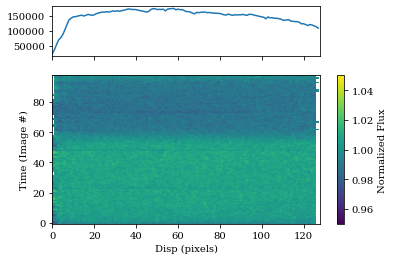

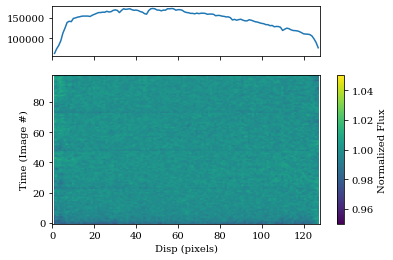

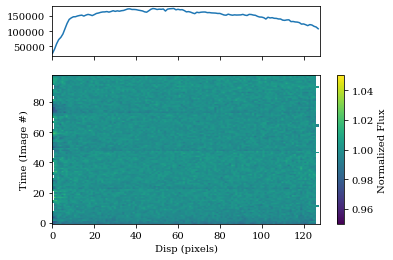

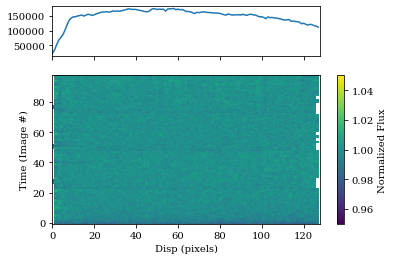

In [11]:
bspec.batch_run('plot_dynamic_spec', showPlot=True,align=True) #plot the dynamic spectrum for each visit

In order to visualize the new alignment with the `plot_wavebin_series` method, one must first generate a new time series from the aligned dynamic spectrum (the step above) using the `make_wavebin_series` method. In the `make_wavebin_series` method arguments, one can set `dispIndicies` to a range that defines the detector pixel indices over which to create the wavelength bins, set `recalculate=True` to recalculate the dynamic spectrum, and set `align=True` to align all the spectra (argument passed to the `plot_dynamic_spec` module. 

Working on make_wavebin_series for batch CoRoT-1 corot1_visit1 
Working on make_wavebin_series for batch CoRoT-1 corot1_visit2 
Working on make_wavebin_series for batch CoRoT-1 corot1_visit3 
Working on make_wavebin_series for batch CoRoT-1 corot1_visit4 
Working on plot_wavebin_series for batch CoRoT-1 corot1_visit1 
Working on plot_wavebin_series for batch CoRoT-1 corot1_visit2 
Working on plot_wavebin_series for batch CoRoT-1 corot1_visit3 
Working on plot_wavebin_series for batch CoRoT-1 corot1_visit4 


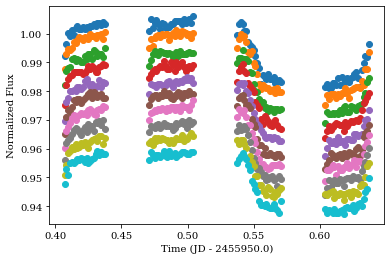

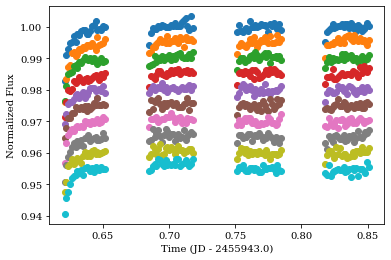

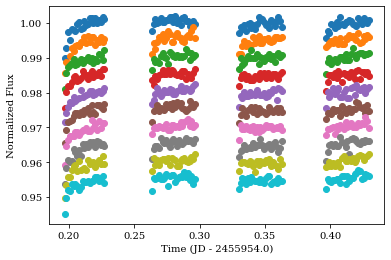

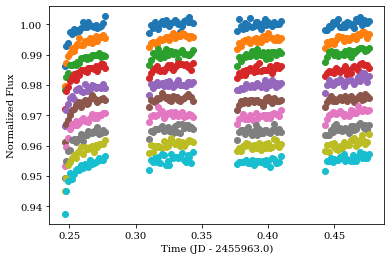

In [116]:
#Bin the wavelengths together and generate a time series from the aligned dynamic spectrum (`make_wavebin_series`)
#Plot a normalized lightcurve for wavelength-binned data one wavelength at a time with an offset between the lightcurves (`plot_wavebin_series`)

bspec.batch_run('make_wavebin_series',align=True,dispIndices=[10,118],recalculate=True,nbins=10) #Set dispersion indices based on alignment step above in `plot_dynamic_spec`.
bspec.batch_run('plot_wavebin_series', nbins=10, interactive=False,savePlot=False)

In [13]:
#Return a spectrometry object for each visit so other methods and attributes can be explored
spec_v1 = bspec.return_spec_obj(ind=0)
spec_v2 = bspec.return_spec_obj(ind=1)
spec_v3 = bspec.return_spec_obj(ind=2)
spec_v4 = bspec.return_spec_obj(ind=3)

In [14]:
#Read in previously saved data for each CoRoT-1 b visit
corot1_visit1_results = pd.read_csv('CSV_Visit_Files/corot1_visit1_results.csv')
corot1_visit2_results = pd.read_csv('CSV_Visit_Files/corot1_visit2_results.csv')
corot1_visit3_results = pd.read_csv('CSV_Visit_Files/corot1_visit3_results.csv')
corot1_visit4_results = pd.read_csv('CSV_Visit_Files/corot1_visit4_results.csv')

#Read in previously saved median images for each CoRoT-1 b visit
median_image_v1 = fits.getdata('Median_Images/corot1_visit1_median_image.fits')
median_image_v2 = fits.getdata('Median_Images/corot1_visit2_median_image.fits')
median_image_v3 = fits.getdata('Median_Images/corot1_visit3_median_image.fits')
median_image_v4 = fits.getdata('Median_Images/corot1_visit4_median_image.fits')

# Original MCMC Analysis Results for CoRoT-1 b

The following is the original MCMC analysis results for each secondary eclipse visit of exoplanet CoRoT-1 b. In particular to this Co-Add visit check notebook, the `MCMC` function found in the `MCMC_Analysis_Functions` script, contains an argument called `Co_add_visit_check`. This argument is set to False by default. However, when set to True, flux data and orbital phase data on each visit will be saved to be used in the `MCMC_Co_add_visit_check` function. 

In [119]:
#Define some global parameters required for the eclipse modeling function within the `Transit_Eclipse_Modeling_Functions` script.
exptime = corot1_visit2_results['Exp Time'][0] #Define the exposure time; Here called from a previously saved table.
Transit_Eclipse_Modeling_Functions.exptime = exptime #Define the global parameter exptime (exposure time) and tell the script specifically 
Transit_Eclipse_Modeling_Functions.im = median_image_v2 #Define the global parameter im (median image) and tell the script specifically

#MCMC Analysis on CoRoT-1 b Visit 2 - if desired: show the light curve plot (`LCPlot=True`) and the distribution plots (`showPlot=True`)
MCMC_2 = MCMC(spec_v2,eclipse_model_RECTE,20000,nbins=10,recalculate=False,showPlot=False,LCPlot=False)

Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [138.62562897 146.32434405 128.95190971 380.93580938 360.32325494
 428.61437663 156.97901502]


Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds


In [118]:
#Define some global parameters required for the eclipse modeling function within the `Transit_Eclipse_Modeling_Functions` script.
exptime = corot1_visit3_results['Exp Time'][0] #Define the exposure time; Here called from a previously saved table.
Transit_Eclipse_Modeling_Functions.exptime = exptime #Define the global parameter exptime (exposure time) and tell the script specifically 
Transit_Eclipse_Modeling_Functions.im = median_image_v3 #Define the global parameter im (median image) and tell the script specifically

#MCMC Analysis on CoRoT-1 b Visit 3 - if desired: show the light curve plot (`LCPlot=True`) and the distribution plots (`showPlot=True`)
MCMC_3 = MCMC(spec_v3,eclipse_model_RECTE,20000,nbins=10,recalculate=False,showPlot=False,LCPlot=False)

Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds


In [120]:
#Define some global parameters required for the eclipse modeling function within the `Transit_Eclipse_Modeling_Functions` script.
exptime = corot1_visit4_results['Exp Time'][0] #Define the exposure time; Here called from a previously saved table.
Transit_Eclipse_Modeling_Functions.exptime = exptime #Define the global parameter exptime (exposure time) and tell the script specifically 
Transit_Eclipse_Modeling_Functions.im = median_image_v4 #Define the global parameter im (median image) and tell the script specifically

#MCMC Analysis on CoRoT-1 b Visit 4 -  if desired: show the light curve plot (`LCPlot=True`) and the distribution plots (`showPlot=True`)
MCMC_4 = MCMC(spec_v4,eclipse_model_RECTE,20000,nbins=10,recalculate=False,showPlot=False,LCPlot=False)

Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds


# Preform the Co-Add Visit Check for CoRoT-1 b
The previous MCMC analysis was done on each visit separately. These results from the MCMC analysis where then used to generate secondary eclipse spectra for each visit. We averaged these secondary eclipse spectra together to get a representative single spectrum of the exoplanet. The following is a different method, which instead phase folds each visit before completing the MCMC analysis. This is a sanity check to our method - to ensure we get the same spectra regardless. 

In [121]:
def eclipse_model_coadd(x, fp, a, b):
    '''
    Models eclipse light curve based on initial parameters stored in params_eclipse.
    
    Parameters
    ----------
    
    x: array
        Orbital phase 
        
    fp: int
        planet-to-star flux ratio
        
    a: int
        Flux Normalization value
        
    b: int
        Slope Flux Normalization value
        
    '''
    #Get the values specific to CoRoT-1b for planet radius and semi-major axis in units of stellar radii.
    rp =1.715 * u.Rjupiter #planet radius rp (in units of Jupiter radii)  #Bonomo et al. 2017
    Rstar = 1.230 * u.Rsun #CoRoT-1 star radius (in units of Solar radii) #Bonomo et al. 2017
    planet_radius = (rp/Rstar).si.value #Calculated - planet radius (in units of stellar radii)
    a_axis = 0.02752 * u.au #semi-major axis (in units of AU) #Bonomo et al. 2017
    a_over_r = (a_axis/Rstar).si.value #Calculated - semi-major axis (in units of stellar radii)
    
    params_eclipse = batman.TransitParams()       #object to store secondary eclipse parameters
    
    params_eclipse.t0 = 0               #Bonomo et al. 2017         #time of inferior conjunction (orbital phase)
    params_eclipse.per = 1.0            #Bonomo et al. 2017         #orbital period (period = 1 in terms of orbital phase)
    params_eclipse.rp =  planet_radius  #Bonomo et al. 2017         #planet radius (in units of stellar radii)
    params_eclipse.a = a_over_r         #Bonomo et al. 2017         #semi-major axis (in units of stellar radii)
    params_eclipse.inc =85.10           #Bonomo et al. 2017         #orbital inclination (in degrees)
    params_eclipse.ecc = 0.             #Bonomo et al. 2017         #eccentricity
    params_eclipse.w = 90.                                          #longitude of periastron (in degrees)
    params_eclipse.limb_dark = "nonlinear"                          #limb darkening model
    params_eclipse.u = [0.5, 0.1, 0.1, -0.1]                        #limb darkening coefficients [u1, u2, u3, u4]
    params_eclipse.t_secondary = params_eclipse.t0 + 0.5* 1.0       #The central eclipse time
    
    params_eclipse.fp = fp/1000000 #planet-to-star flux ratio in ppm
    m = batman.TransitModel(params_eclipse, x, transittype="secondary")
    
    #Modifying the slope: Julian Date(x) - Initial Julian Date(x0) 
    x0 = np.min(x)
    flux = m.light_curve(params_eclipse)*(a+b*(x-x0)) 
    return flux

In [122]:
#Define the log liklihood function; a natural logarithm of the liklihood
#Measures the goodness of fit of a statistical model to a sample of data for given values of the unknown parameters.
#Procedure for obtaining maximum likelihood estimation (the parameter values for the model such that they maximize the likelihood of this model actually being observed) is done in the function `MCMC_Co_add_visit_check`. 
def log_likelihood_coadd(theta, x, y, yerr):
    fp,a,b = theta #the unknown parameters, the blueprint for the model
    model = eclipse_model_coadd(x, fp, a, b) #the model 
    return -0.5 * np.sum((y - model) ** 2 / yerr ** 2)

In [123]:
def MCMC_Co_add_visit_check(spec_obj2, spec_obj3, spec_obj4, model, iterations, nbins=10,recalculate=False,showPlot=False,LCPlot=False):
    
    '''
    Preforms MCMC Analysis on the phase folded data of CoRoT-1 b.  
    
    Parameters
    ----------
    
    spec_obj2: object
        A spectrometry object for CoRoT-1 b Visit 2. 
        
    spec_obj3: object
        A spectrometry object for CoRoT-1 b Visit 3.
    
    spec_obj4: object
        A spectrometry object for CoRoT-1 b Visit 4. 
        
    model: function
        A function that models either transits or secondary eclipses. Must be previously defined.
    
    interation: int
        The number of steps to generate. 
        
    nbins: int
        The number of wavelength bins. The Default is "nbins=10".
        
    recalculate: bool
        Recalculate the MCMC analysis? The Default is "False"
    
    showPlot: bool
        Make the model parameter distribution plots visible? The Default is "False"
    
     LCPlot: bool
        Make the light curve plot visible? The Default is "False"
        
    '''
    
    #For Spec object 2: Grabbing the original data to read in previously saved data. 
    results_spec_obj2 = spec_obj2.get_wavebin_series(nbins=nbins) # all raw results
    raw_results_spec_obj2 = results_spec_obj2[0].to_pandas() #flux raw results
    raw_results_errors_spec_obj2 = results_spec_obj2[1].to_pandas() #flux error raw results
    ydata_columns_spec_obj2 = raw_results_spec_obj2.columns[1:].values # Flux data column names. Skip over the time column. 
    
    #For Spec object 3: Grabbing the original data to read in previously saved data. 
    results_spec_obj3 = spec_obj3.get_wavebin_series(nbins=nbins) # all raw results
    raw_results_spec_obj3 = results_spec_obj3[0].to_pandas() #flux raw results
    raw_results_errors_spec_obj3 = results_spec_obj3[1].to_pandas() #flux error raw results
    ydata_columns_spec_obj3 = raw_results_spec_obj3.columns[1:].values # Flux data column names. Skip over the time column.
    
    #For Spec object 4: Grabbing the original data to read in previously saved data. 
    results_spec_obj4 = spec_obj4.get_wavebin_series(nbins=nbins) # all raw results
    raw_results_spec_obj4 = results_spec_obj4[0].to_pandas() #flux raw results
    raw_results_errors_spec_obj4 = results_spec_obj4[1].to_pandas() #flux error raw results
    ydata_columns_spec_obj4 = raw_results_spec_obj4.columns[1:].values # Flux data column names. Skip over the time column. 
    
    Flux_Error_Merged_Table=pd.concat([raw_results_errors_spec_obj2,raw_results_errors_spec_obj3,raw_results_errors_spec_obj4],axis=0) #merge the raw error results for all visits into one table
    
    #initial guess error for the MCMC analysis  
    avg_error=np.array([4.48073781e+02, 4.90987906e-04, 3.68108798e-03])
    
    Modified_Flux_Table = pd.DataFrame() #empty pandas table to append modified flux data (mean model divided out of the raw data) and orbital phase data 
    
    #Loop through each column of each spec object to read in data simultaneously 
    for columns_2, columns_3, columns_4, bin_number in zip(ydata_columns_spec_obj2,ydata_columns_spec_obj3,ydata_columns_spec_obj4,np.arange(nbins)):
        
        #These lines is used to read in results from a specific folder 
        modified_flux_file_2  = 'Co_add_visit_check/modified_flux_visit_{}_wavelength_ind_{}_nbins{}.csv'.format(spec_obj2.param['nightName'],columns_2,nbins)
        modified_flux_file_3  = 'Co_add_visit_check/modified_flux_visit_{}_wavelength_ind_{}_nbins{}.csv'.format(spec_obj3.param['nightName'],columns_3,nbins)
        modified_flux_file_4  = 'Co_add_visit_check/modified_flux_visit_{}_wavelength_ind_{}_nbins{}.csv'.format(spec_obj4.param['nightName'],columns_4,nbins)
        
        #All paths must exist in order to merge each visits data into one callable table
        if (os.path.exists(modified_flux_file_2) == True) and (os.path.exists(modified_flux_file_3) == True) and (os.path.exists(modified_flux_file_4) == True):
            data_2 = ascii.read(modified_flux_file_2) #read in the saved files
            data_3 = ascii.read(modified_flux_file_3)
            data_4 = ascii.read(modified_flux_file_4)

            orbital_phase_2=data_2['Orbital Phase'] #extract the orbital phase data from each saved file
            orbital_phase_3=data_3['Orbital Phase']
            orbital_phase_4=data_4['Orbital Phase']
            
            #concatenate each visits orbital phase data into one (axis=0)
            merged_orbital_phases = np.concatenate([orbital_phase_2,orbital_phase_3,orbital_phase_3],axis=0)
            
            modified_flux_2=data_2['Modified Flux'] #extract the modified flux data from each saved file
            modified_flux_3=data_3['Modified Flux']
            modified_flux_4=data_4['Modified Flux']
            
            #concatenate each visits modified flux data into one (axis=0)
            merged_modified_flux = np.concatenate([modified_flux_2,modified_flux_3,modified_flux_4],axis=0)
            
            #Add each merged modified flux (3 visits) for each wavebin in an empty pandas dataframe. The bin_number gives how many columns to insert in the table while columns_2 gives each column a name (all visits share these names if they have the same nbins)
            Modified_Flux_Table.insert(int(bin_number),"Orbital Phase "+str(columns_2),merged_orbital_phases) 
            Modified_Flux_Table.insert(int(bin_number),"Modified "+str(columns_2),merged_modified_flux)
            
    Modified_Flux_Table=Modified_Flux_Table.sort_values('Orbital Phase 15.000um Flux') #Sort the table by the orbital phase. 


    #Establish the model in use based on initial function input. Establish the parameters and the initial parameter guess values (p0) for each model. 
    if(model==eclipse_model_coadd):
        labels = ["fp", "a", "b"]
        p0 = [500,1.0,0.0] #each guess value in the list corresponds to the parameter order in text
    else: 
        print("Invalid Model Input") #This function only works on the above previously defined models!
        
    xdata = Modified_Flux_Table["Orbital Phase 15.000um Flux"].values #define orbital phase data. Each wavebin has the same orbital phase since we merged the vists. 
    ydata_errors_columns = Flux_Error_Merged_Table.columns[1:].values # Define the ydata error column names. Skip over the time column
    ydata_columns = Modified_Flux_Table.columns.values #define the ydata column names. There is no time column in this one. 
    
    #Define empty lists to store percentile computations
    q50_array =[] #50th, median
    q16_array =[] #16th, -1 std
    q84_array =[] #84th, +1 std
    
    #Establsih a color map index, to be iterated over, based on the number of wavebins defined. 
    color_idx_range = np.linspace(0.3, 0.8, nbins)
    
    #Set up plotting options for the Light Curve
    if (LCPlot==True):
        fig, (ax2) = plt.subplots(figsize=(20,20)) #Set up the figure space
        
    #Loop over the flux data and their respective flux data error columns simultaneously for each wavelength. 
    #Each wavelength will have an associated color (determined by the color index) and bin number.  
    for columns,columns_errors,bin_number,color_idx in zip(ydata_columns,ydata_errors_columns,np.arange(nbins),color_idx_range):
        
        ydata = Modified_Flux_Table[columns].values #return array of ydata values depending on wavebin
        ydata_errors = Flux_Error_Merged_Table[columns_errors].values #return array of ydata error values depending on wavebin
        
        start_MLE = time.time() #Start of the internal timer for Maximum likelihood estimate

        #This line is used to save results to a specific folder in order to streamline previously run data. (Can be altered)
        result_file = 'Co_add_visit_check/MCMCtest_soln.x_wavelength_ind_{}_nbins{}.csv'.format(columns,nbins)
        
        #If the previously defined results_file exists and the recalculation parameter is set to False, read it in. 
        if (os.path.exists(result_file) == True):
            dat = ascii.read(result_file)
            soln_xarray = dat['soln'] #read in the solution array,the numerical optimums of this likelihood function, the maximum liklihood estimates
            
        #If the previously defined results_file does not exsit or if the recalculation parameter is set to True, call and run the scipy.optimize.minimize function. 
        else:
            #Create a table for these solution array and save them to the results_file defined previously. 
            dat = Table() 
            #run MCMC
            nll = lambda *args: -log_likelihood_coadd(*args) #Define a small anonymous function (nll using lambda) that take all arguments required of the log_probability function. Define the expession to be exectured as the log_probability function. 
            initial = np.array([p0[0],p0[1], p0[2]]) #Define the initial guess values
            soln = minimize(nll, initial, args=(xdata, ydata, ydata_errors)) #Run the scipy.optimize.minimize function to return optimization results.
            soln_xarray = soln.x #Grab and save the solution array. 
            dat['soln'] = soln['x']
            dat.write(result_file)
            
        end_MLE = time.time() #End of the internal timer for Maximum likelihood estimate
        MLE_time= end_MLE-start_MLE
        print("Maximum Likelihood Estimation Took {0:.1f} Seconds".format(MLE_time))
        
        nwalkers = 6 #Define the number of walkers in the ensemble (can vary)
        ndim = 3 #Define the number of parameters in model

        pos = np.empty([nwalkers,ndim]) # Define the shape of the initial state or position vector.
        
        
        #Loop through each element of each array simultaneously (The initial guess error value of each parameter, the MLE value for each parameter, and a range where the index of the returned array pertains to each parameter.  
        for i, j, k in zip(avg_error,soln_xarray,np.arange(ndim)):
            pos[:,k] = j + i* np.random.randn(nwalkers)*10  #Parameters initialized around the maximum likelihood results           
        
        #This line is used to save results to a specific folder in order to streamline previously run MCMC analysis. (Can be altered)
        MCMC_file = '/fenrirdata1/kg_data/sample_chain_coadd/MCMCtest_wavelength_ind_{}_nbins{}.h5'.format(columns,nbins)
        
        #If the previously defined MCMC_file exists and the recalculation parameter is set to False, read it in. 
        if (os.path.exists(MCMC_file) == True) and (recalculate == False):
            sampler = emcee.backends.HDFBackend(MCMC_file, read_only=True) #A reader for existing samplings
            check_step_size = sampler.get_chain() #Check the MCMC step size
            
            #If the step size is less than the defined iterations in the function continue MCMC analysis
            if (check_step_size.shape[0] < iterations):
                print("Found "+str(check_step_size.shape[0])+" steps, running "+ str(iterations - check_step_size.shape[0])+ " more steps.")
                
                with Pool(16) as pool: #preform with multiprocessing
                    new_backend = emcee.backends.HDFBackend(MCMC_file) #In order to save additional emcee runs, rename the backend object
                    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood_coadd, args=(xdata, ydata, ydata_errors), backend=new_backend, pool=pool) #instantiating an EnsembleSampler for emcee
                    
                    #Iterate sampler for nsteps iterations and return the result. 
                    #Set initial state or position vector to NONE in order to resume where run_mcmc last was executed from. Set store=True to save runs. 
                    sampler.run_mcmc(None, iterations-check_step_size.shape[0], progress=True, store =True) 
        #If the previously defined MCMC_file does not exsit or if the recalculation parameter is set to True, run MCMC analysis. 
        else:
            with Pool(16) as pool: #preform with multiprocessing
                
                start_MCMC = time.time() #Start of the internal timer for MCMC analysis

                backend = emcee.backends.HDFBackend(MCMC_file) #Create a backend that stores the chain in memory

                sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood_coadd, args=(xdata, ydata, ydata_errors),backend=backend,pool=pool) #instantiating an EnsembleSampler for emcee
                
                #Iterate sampler for nsteps iterations and return the result.Define initial state or position vector and set store=True to save runs. 
                sampler.run_mcmc(pos, iterations, progress=True,store=True);
                
                end_MCMC = time.time() #End of the internal timer for MCMC analysis
                MCMC_time = end_MCMC - start_MCMC
            print("MCMC Multiprocessing Analysis Took {0:.1f} Seconds".format(MCMC_time))
            
        tau = sampler.get_autocorr_time(quiet=True) #Compute an estimate of the autocorrelation time for each parameter. The parameter quiet=True will return a warning rather than stop the code. 

        burnin = int(2 * np.max(tau)) #Define the "burn-in" steps for each parameter based on its autocorrelation time. To be discarded.
        thin = int(0.5 * np.min(tau)) #Define how to thin the sampler chain. Take only every "thin" steps from the chain.
        
        flat_samples = sampler.get_chain(discard=burnin,thin=thin,flat=True) # Flatten the chain so that we have a flat list of samples
        
        #Define the 50th Percentile for each parameter; the mean 
        q50 = np.percentile(flat_samples,50,axis=0)
        q50_array.append(q50)
        
        #Define the 16th Percentile for each parameter; -1 std
        q16 = np.percentile(flat_samples,16,axis=0)
        q16_array.append(q50-q16) #Define the lower unccertainty limit
        
        #Define the 84th Percentile for each parameter; +1 std
        q84 = np.percentile(flat_samples,84,axis=0)
        q84_array.append(q84-q50) #Define the upper unccertainty limit
        
        #Plotting options for the parameter distributions
        if(showPlot==True):
            fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True) #Set up the figure space
            
            
            samples = sampler.get_chain() #Get the stored chain of MCMC samples

            #Loop through each parameter
            for k in range(ndim):
                ax = axes[k]
                ax.plot(samples[:, :, k], "k", alpha=0.3) #Plot each parameter distribution 
                ax.set_xlim(0, len(samples))
                ax.set_ylabel(labels[k])
                #ax.yaxis.set_label_coords(-0.1, 0.5)
            axes[-1].set_xlabel("Step Number");
            
            corner.corner(flat_samples, labels=labels, quantiles=[0.16, 0.5, 0.84],show_titles=True); #generate a corner plot for each wavebin
        
        #Light Curve Plotting
        if(LCPlot==True):
            
            offset = 0.007 #Define an offset between wavebins
        
            inds = np.random.randint(len(flat_samples), size=10) #Define, at random number, indices of the flat sample to generate models 
            
            #Loop through these indices
            for ind in inds:
                sample = flat_samples[ind] #Pull the parameter values at this index as a sample
                ymodel=model(xdata, *sample) #Plug in these sample values into the model function
                
                ax2.plot(xdata, ymodel-bin_number*offset, color=plt.cm.gist_heat(color_idx), alpha=0.1) #Plot the family of models
            
            ax2.errorbar(xdata, ydata-bin_number*offset, yerr=ydata_errors, color=plt.cm.gist_heat(color_idx), fmt="o", capsize=5) #Plot the light curves with error bars for each wavebin

            log_pb = sampler.get_log_prob(discard=burnin,thin=thin,flat=True) #Get the chain of log probabilities evaluated at the MCMC samples
            maximum_index = np.argmax(log_pb) #Define the maximum log probability
            sample_max = flat_samples[maximum_index] #Pull the parameter values at this index of maximum log probability as sample_max
            ymodel_max = model(xdata, *sample_max) #Plug in these sample_max values into the model function
            ax2.plot(xdata, ymodel_max-bin_number*offset, color="black",linewidth=3) #Plot the Maximum Likelihood model

            #Light Curve Plotting Labels/Legend
            ax2.set_ylabel("Normalized Flux + Offset", fontsize=30)
            ax2.set_xlabel("Orbital Phase", fontsize = 30)
            ax2.tick_params(axis='x', labelsize=20)
            ax2.tick_params(axis='y', labelsize=20)
            ax2.xaxis.offsetText.set_fontsize(20)

            legend_elements = [Line2D([0], [0], color='black', lw=3, label='Maximum Likelihood')]
            ax2.legend(handles=legend_elements, fontsize=20)
        



    return  q50_array, q16_array, q84_array

Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds


/home/kglidic/miniconda3/envs/astroconda/lib/python3.6/site-packages/corner/corner.py:271: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))


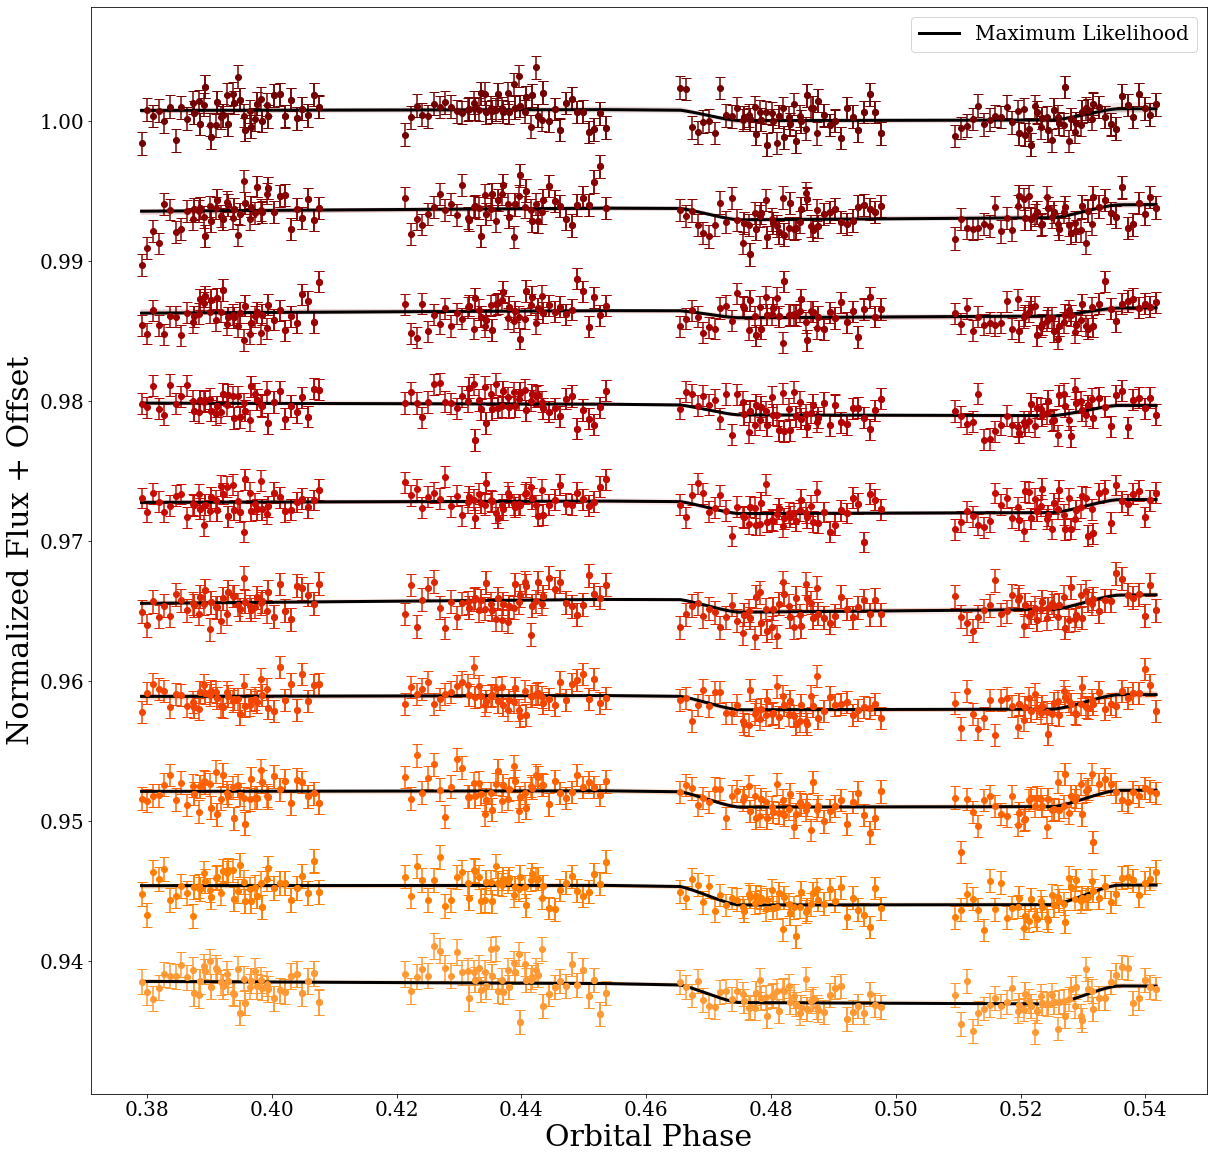

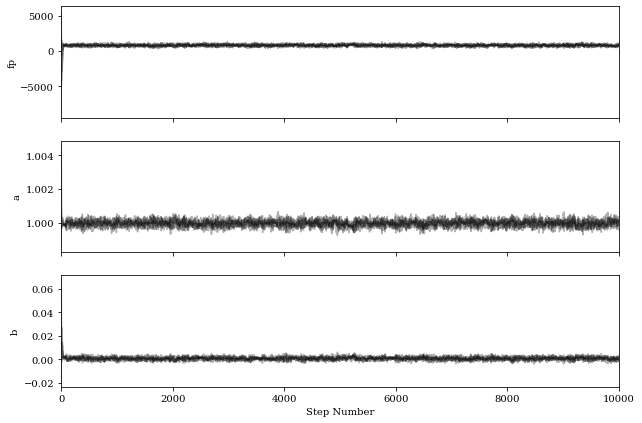

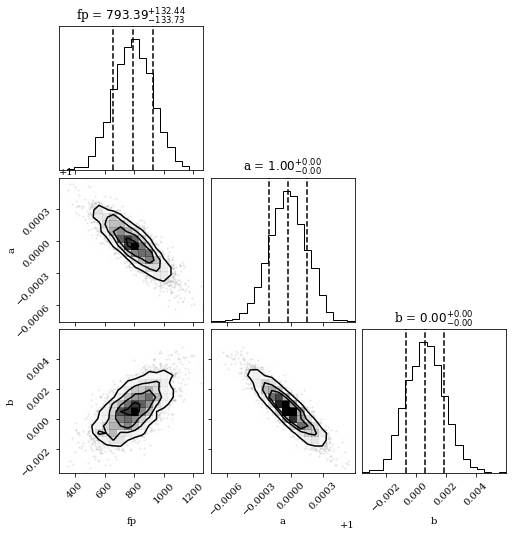

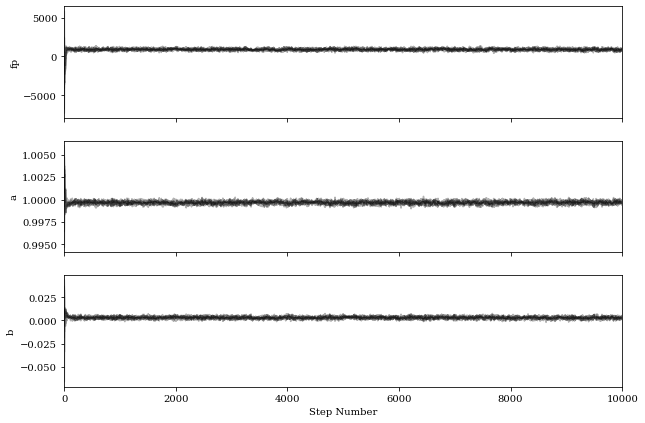

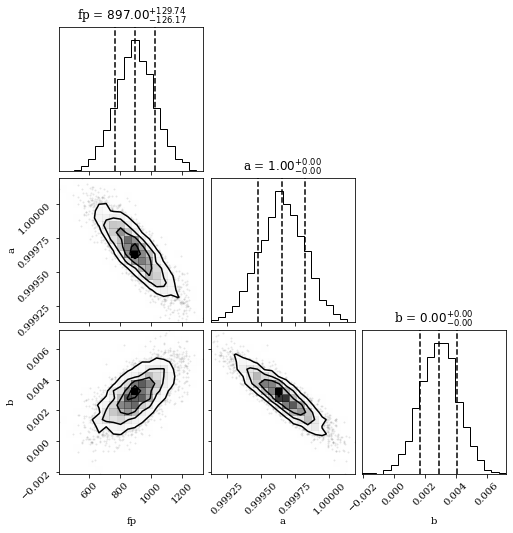

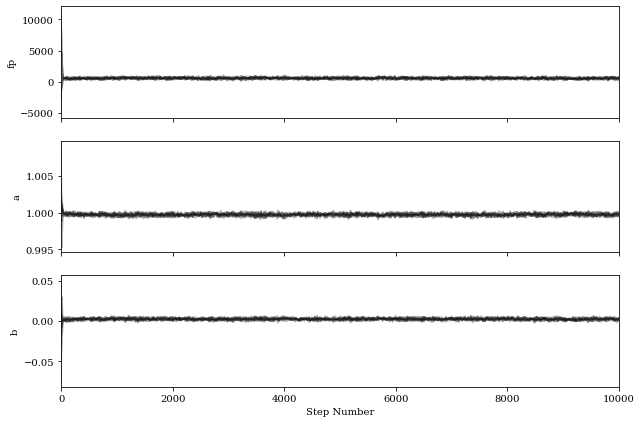

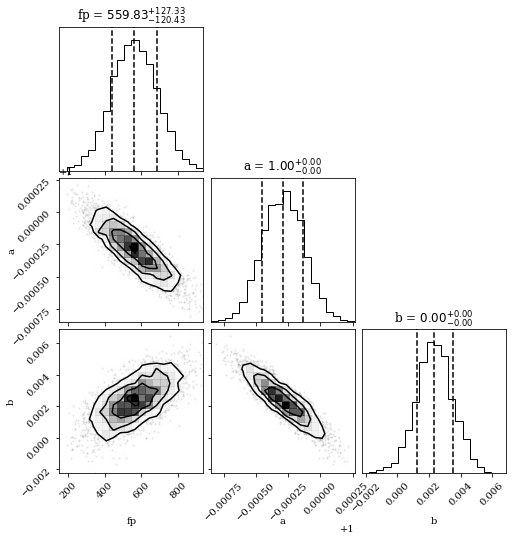

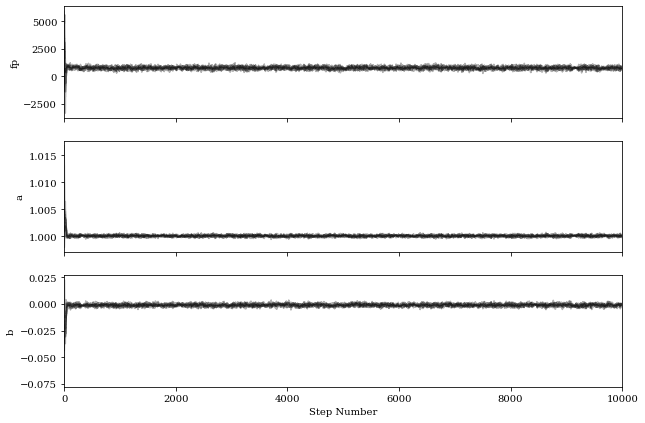

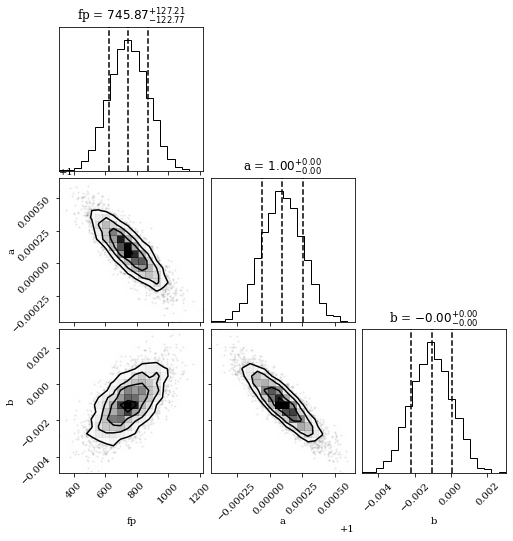

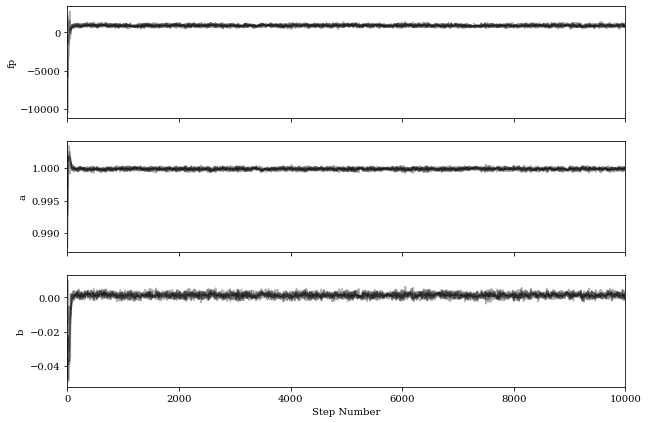

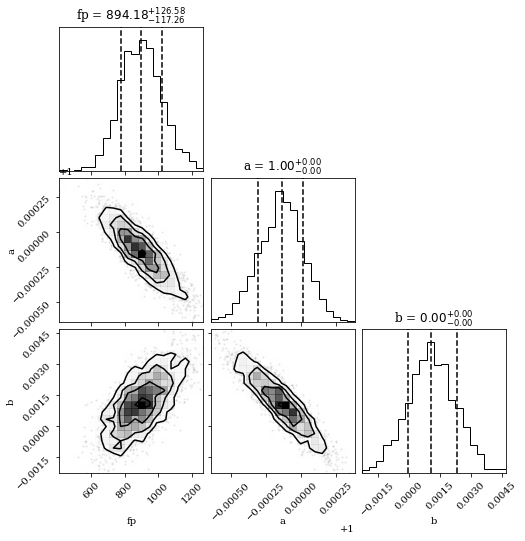

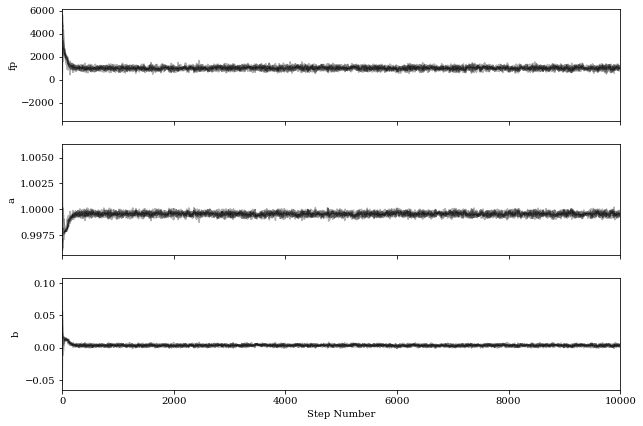

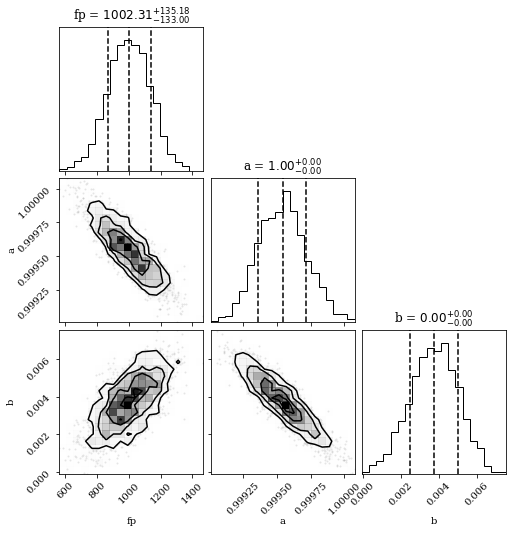

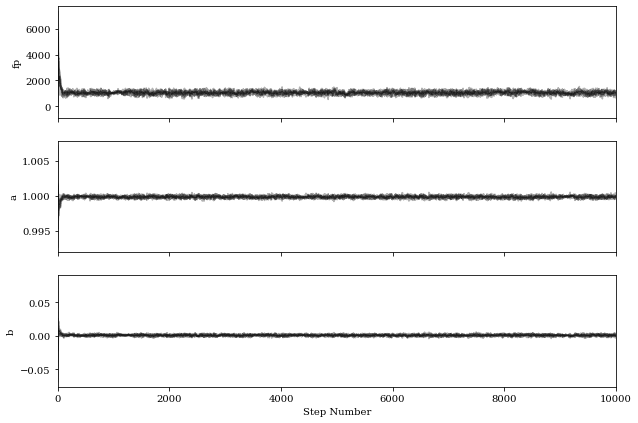

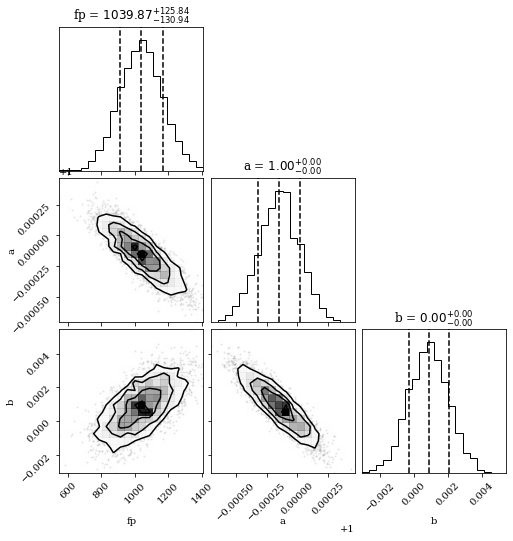

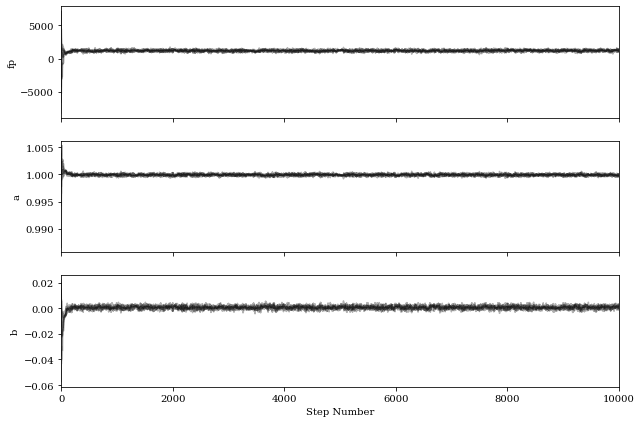

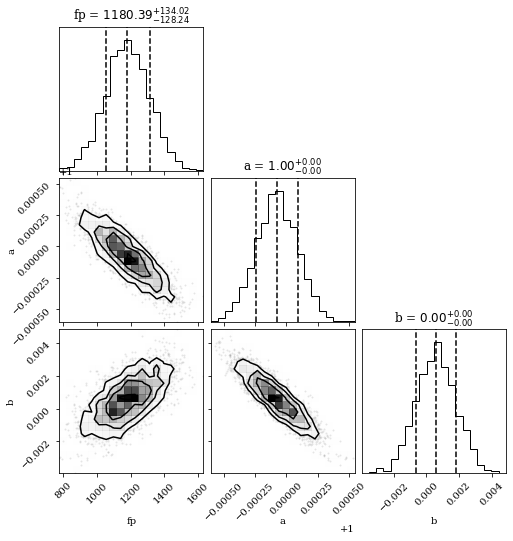

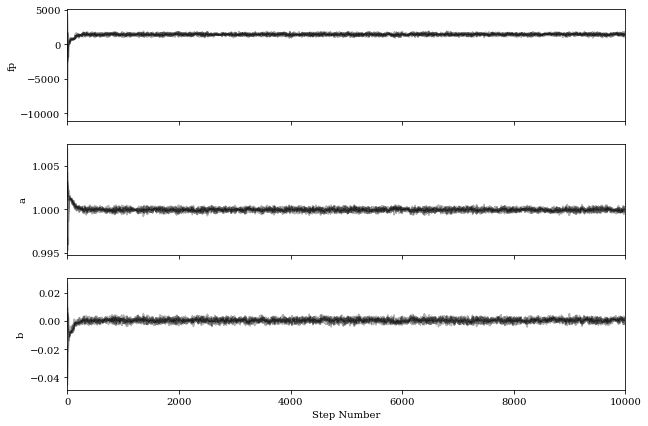

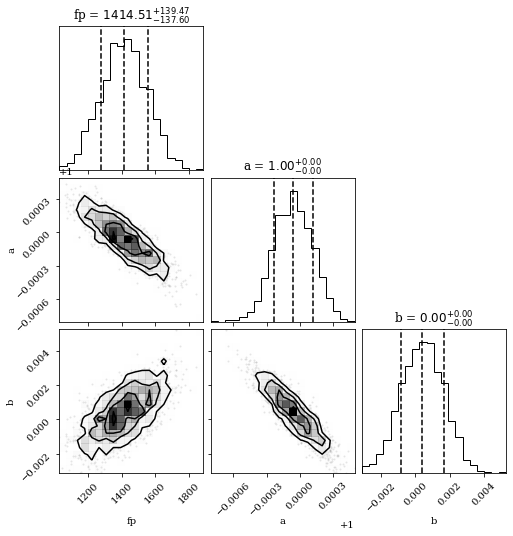

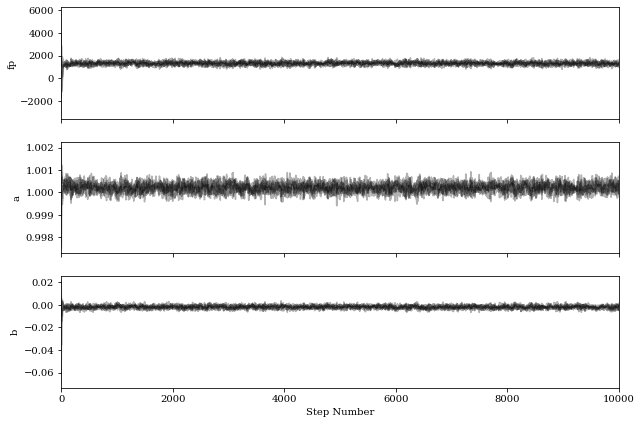

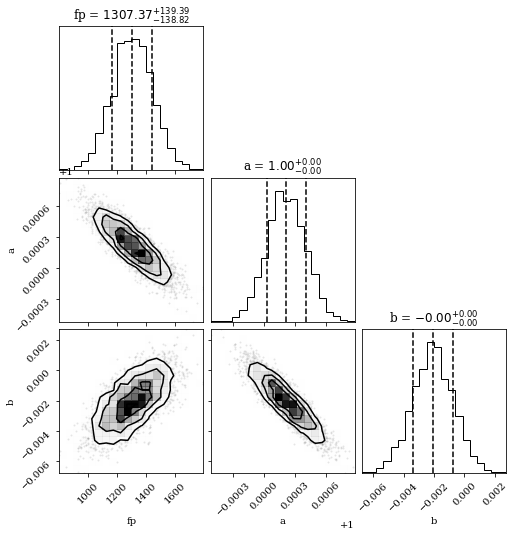

In [124]:
coadd = MCMC_Co_add_visit_check(spec_v2, spec_v3, spec_v3, eclipse_model_coadd,10000, nbins=10,recalculate=False,showPlot=True,LCPlot=True)

In [125]:
#Wavelength Calibrations

#Obtain tables of wavelength bins for each visit, with theoretical noise and measured standard deviation across time.
table_noise_v1=spec_v1.print_noise_wavebin(nbins=10)
table_noise_v2=spec_v2.print_noise_wavebin(nbins=10)
table_noise_v3=spec_v3.print_noise_wavebin(nbins=10)
table_noise_v4=spec_v4.print_noise_wavebin(nbins=10)

#Wavelength calibration to turn the dispersion pixels into wavelengths. 
#CoRoT-1 b used wavecalMethod='wfc3Dispersion' for the HST WFC3 grism
wavelength_list_v1 = spec_v1.wavecal(table_noise_v1['Disp Mid'],waveCalMethod = 'wfc3Dispersion')
wavelength_list_v2 = spec_v2.wavecal(table_noise_v2['Disp Mid'],waveCalMethod = 'wfc3Dispersion')
wavelength_list_v3 = spec_v3.wavecal(table_noise_v3['Disp Mid'],waveCalMethod = 'wfc3Dispersion')
wavelength_list_v4 = spec_v4.wavecal(table_noise_v4['Disp Mid'],waveCalMethod = 'wfc3Dispersion')

In [126]:
#Co-Add Check
q50_values=[item[0] for item in coadd[0]] #the mean value of the flux-to-planet-ratio `item[0]` 
lower_limit=[item[0] for item in coadd[1]] #the lower limit of the error bar for the flux-to-planet-ratio `item[0]` 
upper_limit = [item[0] for item in coadd[2]] #the upper limit of the error bar for the flux-to-planet-ratio `item[0]` 

#Visit 2 - 16,50,84 quantiles
q50_values_2=[item[0] for item in sampler_2[0]] #the mean value of the flux-to-planet-ratio `item[0]` for each wavelength in visit 2
lower_limit_2=[item[0] for item in sampler_2[1]] #the lower limit of the error bar for the flux-to-planet-ratio `item[0]` for each wavelength in visit 2
upper_limit_2 = [item[0] for item in sampler_2[2]] #the upper limit of the error bar for the flux-to-planet-ratio `item[0]` for each wavelength in visit 2

#Visit 3 - 16,50,84 quantiles
q50_values_3=[item[0] for item in sampler_3[0]] #the mean value of the flux-to-planet-ratio `item[0]` for each wavelength in visit 3
lower_limit_3=[item[0] for item in sampler_3[1]] #the lower limit of the error bar for the flux-to-planet-ratio `item[0]` for each wavelength in visit 3
upper_limit_3 = [item[0] for item in sampler_3[2]] #the upper limit of the error bar for the flux-to-planet-ratio `item[0]` for each wavelength in visit 3

#Visit 4 - 16,50,84 quantiles
q50_values_4=[item[0] for item in sampler_4[0]] #the mean value of the flux-to-planet-ratio `item[0]` for each wavelength in visit 4
lower_limit_4=[item[0] for item in sampler_4[1]] #the lower limit of the error bar for the flux-to-planet-ratio `item[0]` for each wavelength in visit 4
upper_limit_4 = [item[0] for item in sampler_4[2]] #the upper limit of the error bar for the flux-to-planet-ratio `item[0]` for each wavelength in visit 4

#Average all three eclipse visits together
average_lower_limit = [(g+h+k) / 3 for g,h,k in zip(lower_limit_2,lower_limit_3,lower_limit_4)] #average the lower limit of the error bars
average_upper_limit = [(g+h+k) / 3 for g,h,k in zip(upper_limit_2,upper_limit_3,upper_limit_4)] #average the upper limits of the error bars
average_q50_values = [(g+h+k) / 3 for g,h,k in zip(q50_values_2,q50_values_3,q50_values_4)] #average the flux-to-planet ratio of all visits for all wavelengths
average_wavelengths = [(g+h+k) / 3 for g,h,k in zip(wavelength_list_v2,wavelength_list_v3,wavelength_list_v4)] #average the wavelengths 

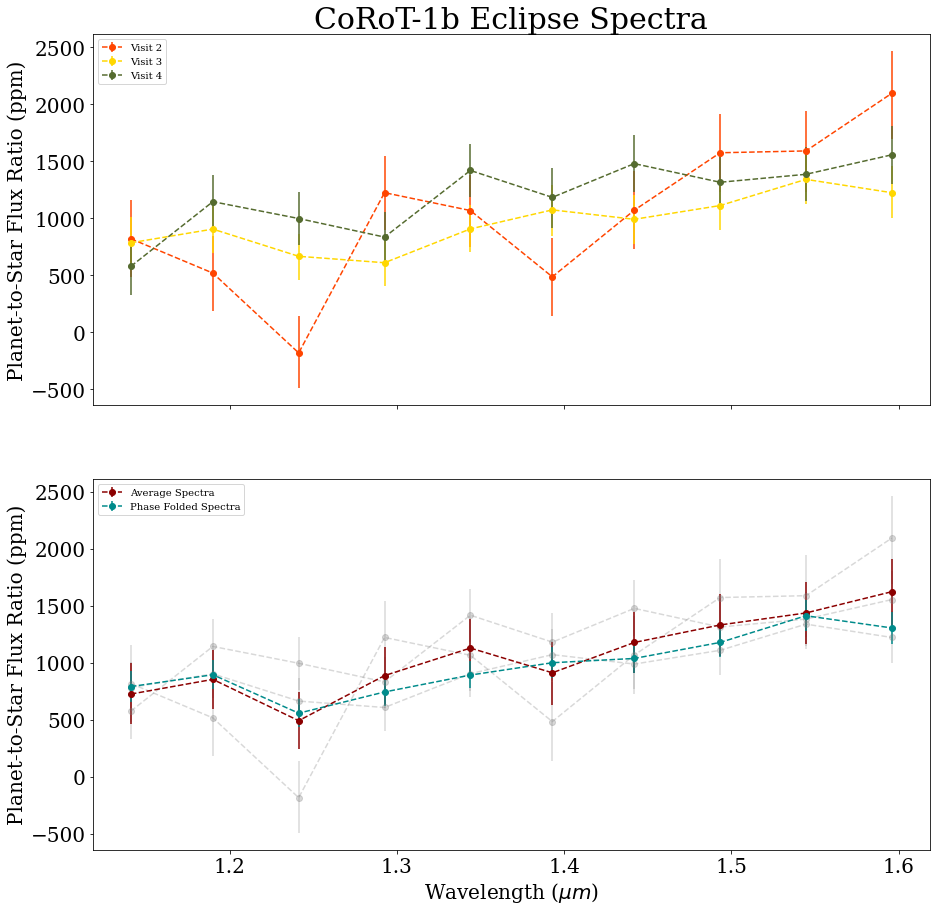

In [127]:
#Plot The Eclipse Spectra

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(15,15), sharex=True) #set up the figure space

#Plot each visit's secondary eclipse spectra overlaid. 
ax1.errorbar(wavelength_list_v2,q50_values_2,yerr=[lower_limit_2, upper_limit_2],label='Visit 2',fmt='--o', color='orangered')
ax1.errorbar(wavelength_list_v3,q50_values_3,yerr=[lower_limit_3, upper_limit_3],label='Visit 3',fmt='--o', color='gold')
ax1.errorbar(wavelength_list_v4,q50_values_4,yerr=[lower_limit_4, upper_limit_4],label='Visit 4',fmt='--o', color='darkolivegreen')
ax1.legend(loc="upper left")

#Plot the average secondary eclipse spectra
ax2.errorbar(wavelength_list_v2,q50_values_2,yerr=[lower_limit_2, upper_limit_2],fmt='--o', color='grey', alpha=0.3) #original specta faded for reference 
ax2.errorbar(wavelength_list_v3,q50_values_3,yerr=[lower_limit_3, upper_limit_3],fmt='--o', color='grey', alpha=0.3) #original specta faded for reference
ax2.errorbar(wavelength_list_v4,q50_values_4,yerr=[lower_limit_4, upper_limit_4],fmt='--o', color='grey', alpha=0.3) #original specta faded for reference
ax2.errorbar(average_wavelengths,average_q50_values,yerr=[average_lower_limit,average_upper_limit],label='Average Spectra',fmt='--o', color="darkred")
ax2.errorbar(average_wavelengths, q50_values, yerr=[lower_limit,upper_limit], label = 'Phase Folded Spectra', fmt='--o', color="darkcyan")
ax2.legend(loc="upper left")

#Plot labels
ax1.set_title("CoRoT-1b Eclipse Spectra", fontsize = 30)
ax1.set_ylabel("Planet-to-Star Flux Ratio (ppm)", fontsize=20)
ax2.set_ylabel("Planet-to-Star Flux Ratio (ppm)", fontsize=20)
ax2.set_xlabel("Wavelength ($\mu m$)", fontsize=20)
ax1.tick_params(axis = 'both',labelsize = 20)
ax2.tick_params(axis = 'both',labelsize = 20)


fig.savefig('saved_figures/CoRoT-1b_MCMC_CoAddCheck_Eclipse_Spectra.jpeg', bbox_inches='tight')
